In [90]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [91]:
import warnings
warnings.simplefilter(action='ignore')

In [92]:
import numpy as np
import pandas as pd
import datetime as dt
import fbprophet
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [93]:
pd.options.display.max_rows=100

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
products = pd.read_csv('/content/drive/MyDrive/project1/products.csv')
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [96]:
del products['product_name_lenght'], products['product_description_lenght'], products['product_photos_qty']
products

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,700.0,31.0,13.0,20.0


In [97]:
products['product_volume_cm3'] = products.product_length_cm*products.product_height_cm*products.product_width_cm
products

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0,20.0,17.0,13.0,4420.0
...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,12300.0,40.0,40.0,40.0,64000.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,1700.0,16.0,19.0,16.0,4864.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,1400.0,27.0,7.0,27.0,5103.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,700.0,31.0,13.0,20.0,8060.0


In [98]:
#количество уникальных продуктов
products.product_id.nunique()

32951

In [99]:
products.isna().sum()

product_id                 0
product_category_name    610
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
product_volume_cm3         2
dtype: int64

Проверим, стоит ли товары с отсутствующей категорией (Other) разбивать еще на несколько категорий, сравнив среднее и среднеквадратическое отклонение в этой категории с данными характеристиками других категорий

In [100]:
products.groupby(['product_category_name']).agg({'product_volume_cm3':'mean'}).sort_values(by='product_volume_cm3')

,product_volume_cm3
product_category_name,
dvds_blu_ray,1746.854167
telefonia,1865.841270
livros_importados,1935.387097
livros_tecnicos,2758.991870
relogios_presentes,3470.398044
livros_interesse_geral,3900.046296
fashion_bolsas_e_acessorios,4480.634865
fashion_underwear_e_moda_praia,4584.132075
audio,4970.172414


In [101]:
products.groupby(['product_category_name']).agg({'product_volume_cm3':'std'}).sort_values(by='product_volume_cm3')

,product_volume_cm3
product_category_name,
livros_importados,1206.736803
pc_gamer,1620.278165
telefonia,2023.848886
dvds_blu_ray,2896.124152
livros_tecnicos,3084.661858
livros_interesse_geral,3503.460753
fashion_roupa_infanto_juvenil,3800.294752
relogios_presentes,4020.254201
flores,4789.929803


In [102]:
products.fillna({'product_category_name':'Other'}, inplace=True)

In [103]:
order_items = pd.read_csv('/content/drive/MyDrive/project1/order_items.csv', parse_dates=[4])
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [104]:
order_items.product_id.nunique()

32951

In [105]:
orders = pd.read_csv('/content/drive/MyDrive/project1/orders.csv', parse_dates=['order_approved_at'])
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [106]:
full_data = pd.merge(order_items, orders.loc[:, ['order_id', 'order_delivered_customer_date']], on='order_id', how='left')
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_delivered_customer_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-20 23:43:48
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-05-12 16:04:24
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-22 13:19:16
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-14 13:32:39
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-03-01 16:42:31
...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-05-10 22:56:40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-23 20:31:55
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-28 12:22:22
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-16 21:59:40


In [107]:
full_data = pd.merge(full_data, products, on='product_id', how='left')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_delivered_customer_date,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-20 23:43:48,cool_stuff,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-05-12 16:04:24,pet_shop,30000.0,50.0,30.0,40.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-22 13:19:16,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-14 13:32:39,perfumaria,200.0,16.0,10.0,15.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-03-01 16:42:31,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-05-10 22:56:40,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-23 20:31:55,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-28 12:22:22,esporte_lazer,967.0,21.0,24.0,19.0,9576.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-16 21:59:40,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0


In [108]:
full_data.product_category_name.nunique()

74

In [109]:
full_data['Index'] = range(len(full_data))

In [110]:
translation = pd.read_csv('/content/drive/MyDrive/project1/product_category_name_translation.csv')

In [111]:
translation

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


In [112]:
full_data  = pd.merge(full_data, translation, on='product_category_name', how='left')

In [113]:
full_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_delivered_customer_date,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,Index,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-20 23:43:48,cool_stuff,650.0,28.0,9.0,14.0,3528.0,0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-05-12 16:04:24,pet_shop,30000.0,50.0,30.0,40.0,60000.0,1,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-22 13:19:16,moveis_decoracao,3050.0,33.0,13.0,33.0,14157.0,2,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-14 13:32:39,perfumaria,200.0,16.0,10.0,15.0,2400.0,3,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-03-01 16:42:31,ferramentas_jardim,3750.0,35.0,40.0,30.0,42000.0,4,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-05-10 22:56:40,utilidades_domesticas,10150.0,89.0,15.0,40.0,53400.0,112645,housewares
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-23 20:31:55,informatica_acessorios,8950.0,45.0,26.0,38.0,44460.0,112646,computers_accessories
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-28 12:22:22,esporte_lazer,967.0,21.0,24.0,19.0,9576.0,112647,sports_leisure
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-16 21:59:40,informatica_acessorios,100.0,20.0,20.0,20.0,8000.0,112648,computers_accessories


In [114]:
full_data = full_data.loc[:, ['product_id', 'seller_id', 'product_category_name_english','order_delivered_customer_date']]
full_data = full_data.sort_values(by='order_delivered_customer_date')
full_data

,product_id,seller_id,product_category_name_english,order_delivered_customer_date
23966,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,furniture_decor,2016-10-11 13:46:32
23965,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,furniture_decor,2016-10-11 13:46:32
49383,35084deab9603bbb6035bb8638b1df89,df560393f3a51e74553ab94004ba5c87,furniture_decor,2016-10-11 14:46:49
92532,c3b8f6be3507bb05fd83797f81f679bc,2138ccb85b11a4ec1e37afbd1c8eda1f,telephony,2016-10-13 03:10:34
64210,f07ef9dd6e2d9a366ff30a25e210be70,62c50c1af4dfdc4149d25c5222043d39,fixed_telephony,2016-10-13 07:45:48
...,...,...,...,...
112211,0c7536abc1af51a81fa806097dfe3597,7d76b645482be4a332374e8223836592,telephony,NaN
112256,b27653c33039497c46ceba21db46a43c,3e8bd881d92466e63ba9e3e809cd3c50,computers_accessories,NaN
112340,6803077179d24889430188e03fafd31a,128639473a139ac0f3e5f5ade55873a5,electronics,NaN
112384,53d2c16e7356d124bb2a3f64ca920754,4e922959ae960d389249c378d1c939f5,sports_leisure,NaN


In [115]:
full_data.fillna({'product_category_name_english':'Other'}, inplace=True)

In [116]:
full_data.isna().sum()

product_id                          0
seller_id                           0
product_category_name_english       0
order_delivered_customer_date    2454
dtype: int64

In [117]:
full_data.dropna(inplace=True)

Отберем товары, которые продавались больше 1 раза

In [118]:
not_new_prod_id = full_data.groupby('product_id', as_index=False).agg('count')
not_new_prod_id = not_new_prod_id[not_new_prod_id.order_delivered_customer_date > 1]
not_new_prod_id = not_new_prod_id.product_id
not_new_prod_id

3        000b8f95fcb9e0096488278317764d19
6        00126f27c813603687e6ce486d909d01
7        001795ec6f1b187d37335e1c4704762e
9        001b72dfd63e9833e8c02742adf472e3
11       00210e41887c2a8ef9f791ebc780cc36
                       ...               
32203    ffedbd68fa6f44e788ff6c2db8094715
32204    ffef256879dbadcab7e77950f4f4a195
32205    fff0a542c3c62682f23305214eaeaa24
32209    fff6177642830a9a94a0f2cba5e476d1
32212    fffdb2d0ec8d6a61f0a0a0db3f25b441
Name: product_id, Length: 14498, dtype: object

In [119]:
full_data = full_data[full_data.product_id.isin(not_new_prod_id)]
full_data

,product_id,seller_id,product_category_name_english,order_delivered_customer_date
23966,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,furniture_decor,2016-10-11 13:46:32
23965,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,furniture_decor,2016-10-11 13:46:32
92532,c3b8f6be3507bb05fd83797f81f679bc,2138ccb85b11a4ec1e37afbd1c8eda1f,telephony,2016-10-13 03:10:34
64210,f07ef9dd6e2d9a366ff30a25e210be70,62c50c1af4dfdc4149d25c5222043d39,fixed_telephony,2016-10-13 07:45:48
36169,b6f134ff2933bb0ee1f36e2865f21a91,0c8380b62e38e8a1e6adbeba7eb9688c,furniture_decor,2016-10-13 15:45:44
...,...,...,...,...
106581,d04857e7b4b708ee8b8b9921163edba3,9f505651f4a6abe901a56cdc21508025,computers_accessories,2018-09-21 23:46:29
54987,9fe172fa8e662ca8572cf12abf8bce23,cab85505710c7cb9b720bceb52b01cee,fashion_bags_accessories,2018-09-25 00:47:25
71337,ddceb6eef6af67e9fbbd4c148dbe5fd9,ceaec5548eefc6e23e6607c5435102e7,cool_stuff,2018-09-27 02:24:33
78512,78efe838c04bbc568be034082200ac20,0241d4d5d36f10f80c644447315af0bd,furniture_decor,2018-10-02 00:18:50


In [120]:
full_data['order_delivered_customer_date'] = pd.to_datetime(full_data['order_delivered_customer_date'])

In [121]:
full_data.order_delivered_customer_date = full_data.order_delivered_customer_date.dt.date
full_data = full_data.rename(columns={'order_delivered_customer_date': 'date'})

In [122]:
dateCount = Counter()
for day in full_data.date:
    dateCount[day] += 1
dateCount = pd.DataFrame.from_dict(dateCount, orient='index', columns=['Sales'])
dateCount.describe()

,Sales
count,638.000000
mean,144.952978
std,121.254307
min,1.000000
25%,23.250000
50%,126.000000
75%,253.750000
max,460.000000


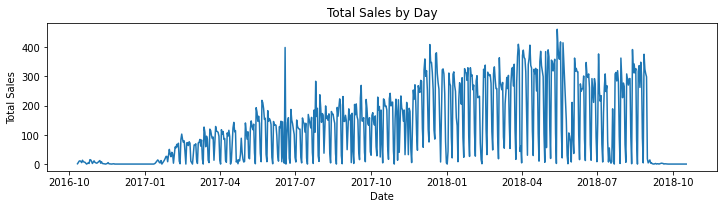

In [123]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
dateCount.plot(ax = ax1, legend=None)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day')
print()

In [169]:
full_data_cropped = full_data[(full_data['date'] >= pd.to_datetime('2017-06-01').date()) & (full_data['date'] <= pd.to_datetime('2018-09-05').date())].copy()

In [170]:
dateCountCropped = Counter()
for day in full_data_cropped.date:
    dateCountCropped[day] += 1
dateCountCropped = pd.DataFrame.from_dict(dateCountCropped, orient='index', columns=['Sales'])
dateCountCropped.describe()

,Sales
count,455.000000
mean,183.123077
std,119.692734
min,1.000000
25%,77.000000
50%,180.000000
75%,292.000000
max,460.000000


In [171]:
dateCountCropped[dateCountCropped.index >= pd.to_datetime('2018-07-06').date()]

,Sales
2018-07-06,234
2018-07-07,69
2018-07-08,8
2018-07-09,177
2018-07-10,262
2018-07-11,308
2018-07-12,248
2018-07-13,268
2018-07-14,79
2018-07-15,8


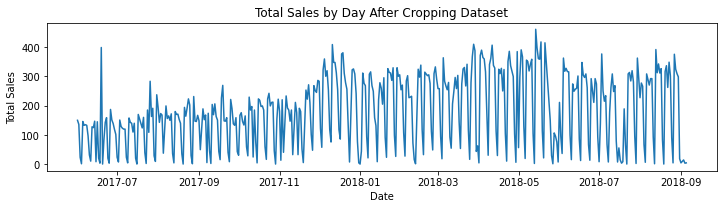

In [172]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
dateCountCropped.plot(ax = ax1, legend=None)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales by Day After Cropping Dataset')
print()

In [173]:
prod_id_sells = full_data_cropped.groupby(['product_category_name_english', 'date']).agg({'date':'count'})
prod_id_sells = prod_id_sells.rename({'date':'sells_val'}, axis='columns')
prod_id_sells.reset_index(level='date', inplace = True)
prod_id_sells.reset_index(inplace=True)

В основном у нас меньше 5 продаж в день

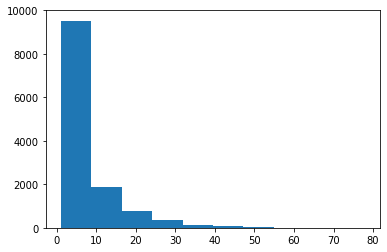

In [174]:
plt.hist(prod_id_sells['sells_val'])
plt.show()

Заполним месяца, в которых не было продаж товара, нулями

In [175]:
df = prod_id_sells.copy()
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['date']
df_interpol = df.groupby(['product_category_name_english']).resample('W').sum()
df_interpol['sells_val'] = df_interpol['sells_val'].fillna(0)

In [176]:
df_interpol = df_interpol.reset_index()

In [177]:
del df_interpol['date']
series = df_interpol.groupby(['product_category_name_english'])['sells_val'].apply(list).to_dict()

In [178]:
df_interpol.describe(include = 'all')

,product_category_name_english,sells_val
count,4262,4262.000000
unique,71,NaN
top,fashion_bags_accessories,NaN
freq,67,NaN
mean,NaN,19.549742
std,NaN,34.439403
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,4.000000
75%,NaN,22.000000


Отеберем товары, которые продавались больше 2 месяцев, для того, чтобы ипользовать последний месяц в качестве тест-выборки

In [179]:
# Создадим словарь для продуктов, которые продавались меньше 60 дней
series_unpopular_product = dict()

In [180]:
for k in series.copy():
    if len(series[k]) < 8:
        series_unpopular_product[k] = series[k]
        del series[k]

In [181]:
len(series)

70

In [182]:
len(series_unpopular_product)

1

### Словарь с необходимыми временными рядами

In [183]:
from statsmodels.tsa.stattools import adfuller
p_values = {}
for i in df_interpol['product_category_name_english'].unique():
  df = df_interpol[df_interpol['product_category_name_english'] == i]
  del df['product_category_name_english']
  df['z_data'] = (df['sells_val'] - df.sells_val.rolling(window=12).mean()) / df.sells_val.rolling(window=12).std()
  df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

  print(f'{i} class:')
  print(" > Is the data stationary ?")
  try:
    dftest = adfuller(df['sells_val'], autolag='AIC')
  except:
    p_values[i] = 0
    continue
  print("Test statistic = {:.3f}".format(dftest[0]))
  print("P-value = {:.3f}".format(dftest[1]))
  p_values[i] = np.round(dftest[1], 3)

Other class:
 > Is the data stationary ?
Test statistic = -3.159
P-value = 0.023
agro_industry_and_commerce class:
 > Is the data stationary ?
Test statistic = -5.006
P-value = 0.000
air_conditioning class:
 > Is the data stationary ?
Test statistic = -6.844
P-value = 0.000
art class:
 > Is the data stationary ?
Test statistic = -0.669
P-value = 0.855
arts_and_craftmanship class:
 > Is the data stationary ?
Test statistic = -3.069
P-value = 0.029
audio class:
 > Is the data stationary ?
Test statistic = -4.457
P-value = 0.000
auto class:
 > Is the data stationary ?
Test statistic = -1.016
P-value = 0.747
baby class:
 > Is the data stationary ?
Test statistic = -2.301
P-value = 0.172
bed_bath_table class:
 > Is the data stationary ?
Test statistic = -4.593
P-value = 0.000
books_general_interest class:
 > Is the data stationary ?
Test statistic = -3.042
P-value = 0.031
books_imported class:
 > Is the data stationary ?
Test statistic = -7.024
P-value = 0.000
books_technical class:
 > Is t

## Прогнозирование

In [186]:
params_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
grid = ParameterGrid(params_grid)

In [ ]:
final_preds = {}
errors = []
for i in df_interpol['product_category_name_english'].unique():
  if i in series:
    SKU_sells = prod_id_sells[prod_id_sells.product_category_name_english == i]

    first_sale = SKU_sells.date.min()
    last_sale = SKU_sells.date.max()

    dates_list = []
    for j in range(len(series[i])):
        dates_list.append(first_sale + relativedelta(days=+j))
    
    SKU_df = pd.DataFrame({'date':dates_list, 'sells_val':series[i]})
    SKU_df.columns = ['ds', 'y']

    SKU_train_df = SKU_df.iloc[:-3,]
    SKU_test_df = SKU_df.iloc[-3:,]
    
    print(f'Making prediction of {i} with Prophet model')

    err = np.ndarray([])
    err_ = []
    for p in grid:
      m = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, uncertainty_samples=False)
      m.fit(SKU_train_df)
      pr = m.predict(SKU_test_df.drop(['y'], axis=1))
      pr = pr.loc[:,['ds', 'yhat']]
      pr.yhat = pr.yhat.where(pr.yhat>=0, 0)
      err = np.append(err, mean_absolute_percentage_error(SKU_test_df.y, pr.yhat))
      if (0 in SKU_test_df.y.values) or (0 in pr.yhat.values):
        continue
      err_.append(mean_absolute_percentage_error(SKU_test_df.y, pr.yhat))
    
    p = grid[err.argmin()]

    if len(err_) > 0:
      errors.append(min(err_))

    fb_model = fbprophet.Prophet(**p, 
                                 daily_seasonality=False, 
                                 weekly_seasonality=True, 
                                 yearly_seasonality=False, 
                                 uncertainty_samples=False)
    fb_model.fit(SKU_df)
    future = fb_model.make_future_dataframe(periods=3, freq='W', include_history=False)
    predictions = fb_model.predict(future)
    predictions.yhat = predictions.yhat.where(predictions.yhat>=0, 0)
    predictions = predictions.loc[:,['ds', 'yhat']]
    predictions = predictions[1:].reset_index(drop=True) # Отбросим первую неделю, поскольку заказчику был необходим прогноз по истечению недели со дня последней продажи
    predictions.columns = ['Date', 'Prediction']
    final_preds[i] = np.round(predictions)

  if i in series_unpopular_product:
      
    print(f'Making prediction of {i} with linear model')
    unpop_dates_list = []
    for k in range(1, 4): # Создаем последовательность дат на 21 день с момента последней продажи продукта
        unpop_dates_list.append(last_sale + relativedelta(weeks=+k))
          
    lm = LinearRegression()
    lm.fit(np.arange(1,len(series_unpopular_product[i]) + 1).reshape(-1, 1), series_unpopular_product[i])
    lm_predictions = lm.predict(np.arange(len(series_unpopular_product[i]) + 1, len(series_unpopular_product[i]) + 1 + 3).reshape(-1, 1))
    lm_predictions = np.where(lm_predictions >= 0, lm_predictions, 0)
    predictions = pd.DataFrame({'Date':unpop_dates_list, 'Prediction':lm_predictions})
    predictions = predictions[1:].reset_index(drop=True) # Отбросим первую неделю, поскольку заказчику был необходим прогноз по истечению недели со дня последней продажи
    final_preds[i] = np.round(predictions)
  

Making prediction of Other with Prophet model
Making prediction of agro_industry_and_commerce with Prophet model
Making prediction of air_conditioning with Prophet model
Making prediction of art with Prophet model
Making prediction of arts_and_craftmanship with linear model
Making prediction of audio with Prophet model
Making prediction of auto with Prophet model
Making prediction of baby with Prophet model
Making prediction of bed_bath_table with Prophet model
Making prediction of books_general_interest with Prophet model
Making prediction of books_imported with Prophet model
Making prediction of books_technical with Prophet model
Making prediction of cds_dvds_musicals with Prophet model
Making prediction of christmas_supplies with Prophet model
Making prediction of cine_photo with Prophet model
Making prediction of computers with Prophet model
Making prediction of computers_accessories with Prophet model
Making prediction of consoles_games with Prophet model
Making prediction of cons

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


Making prediction of fashion_childrens_clothes with Prophet model


INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.

Making prediction of fashion_male_clothing with Prophet model
Making prediction of fashion_shoes with Prophet model


INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


Making prediction of fashion_sport with Prophet model


INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.

Making prediction of fashion_underwear_beach with Prophet model
Making prediction of fixed_telephony with Prophet model


INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


Making prediction of flowers with Prophet model


INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.

Making prediction of food with Prophet model
Making prediction of food_drink with Prophet model
Making prediction of furniture_bedroom with Prophet model
Making prediction of furniture_decor with Prophet model
Making prediction of furniture_living_room with Prophet model
Making prediction of furniture_mattress_and_upholstery with Prophet model
Making prediction of garden_tools with Prophet model
Making prediction of health_beauty with Prophet model
Making prediction of home_appliances with Prophet model
Making prediction of home_appliances_2 with Prophet model
Making prediction of home_comfort_2 with Prophet model
Making prediction of home_confort with Prophet model
Making prediction of home_construction with Prophet model
Making prediction of housewares with Prophet model
Making prediction of industry_commerce_and_business with Prophet model
Making prediction of kitchen_dining_laundry_garden_furniture with Prophet model
Making prediction of la_cuisine with Prophet model
Making predict

In [ ]:
errors.sum()/len(errors)

In [ ]:
final_preds